In [2]:

# Heavily borrows from https://github.com/Priesemann-Group/covid19_inference

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

import pandas as pd
import datetime

import pymc3 as pm

import pickle
import datetime

import theano
import theano.tensor as tt
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

import sys
sys.path.append('..')
import ModelInfo



<MultiTrace: 2 chains, 527 iterations, 44 variables>
(1054, 100)
2020-03-03 00:00:00 3.875741014394066
2020-03-04 00:00:00 3.953742939889038
2020-03-05 00:00:00 3.9134771383496885
2020-03-06 00:00:00 3.8099939632714275
2020-03-07 00:00:00 3.6509191188328476
2020-03-08 00:00:00 3.328489817875003
2020-03-09 00:00:00 2.950970002191199
2020-03-10 00:00:00 2.5821191461980164
2020-03-11 00:00:00 2.251260205301354
2020-03-12 00:00:00 1.9657363437540716
2020-03-13 00:00:00 1.6854288046451054
2020-03-14 00:00:00 1.4476004120308301
2020-03-15 00:00:00 1.2523861095870188
2020-03-16 00:00:00 1.1116255802029646
2020-03-17 00:00:00 0.995024233428682
2020-03-18 00:00:00 0.9196066567241278
2020-03-19 00:00:00 0.8697112436290539
2020-03-20 00:00:00 0.8606403983286299
2020-03-21 00:00:00 0.8487494655210106
2020-03-22 00:00:00 0.8390616209315062
lambda_t_random_walk (1054, 100) 
delay_ratio_t_random (1054, 11) 
new_day_curve_studen (1054, 1) 0.308 
f_death              (1054,) 0.071±0.001
m_death        

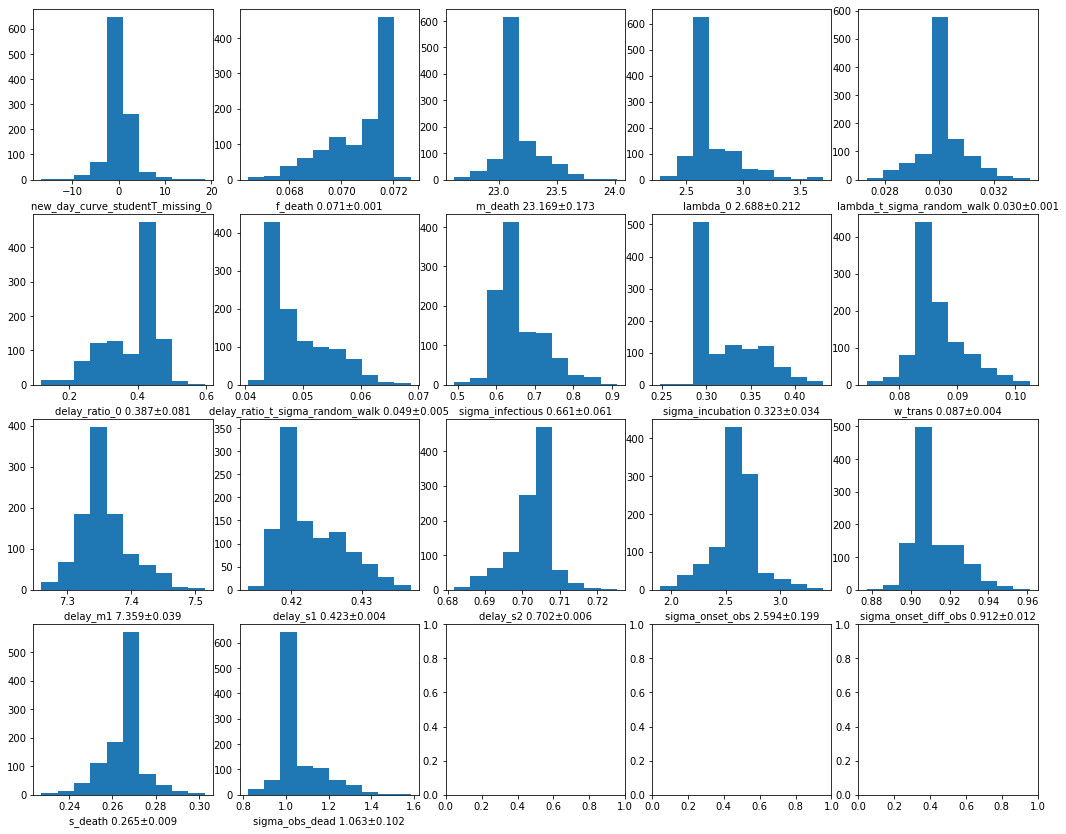

In [35]:

with open("../traces/trace154930.dat","rb") as f:
#with open("../traces/trace151050.dat","rb") as f:
    trace = pickle.load(f)
    model = pickle.load(f)
    datasets = pickle.load(f)

with open("../data/onset_by_date_missing.pickle","rb") as f:
    onsets_per_date = pickle.load(f)

with open("../data/onsets_by_date_diff.pickle","rb") as f:
    onsets_per_date_diff = pickle.load(f)
    
print(trace)
#print(trace.lambda_t_random_walk.shape)
print(trace.lambda_t.shape)
ts = pd.date_range(model.startdate,periods=model.length,freq='D')
for t,l in zip(ts[20:40],np.mean(trace.lambda_t,axis=0)[20:40]):
    print(t,l)

trd = {}
for name in trace.varnames:
    if "log__" not in name and "interval__" not in name:
        
        s,dt = "",trace[name]
        
        if dt.ndim == 1:
            s = "%.3f±%.3f"%(np.mean(dt,axis=0),np.std(dt,axis=0))
            trd[name] = (dt,s,)
        elif dt.shape[1] < 10 and dt.ndim==2:
            m = np.mean(dt,axis=0)
            trd[name+"_0"] = (dt[:,0],"")
            for v in m:
                s += "%.3f "%v
        print((name+" "*20)[:20],trace[name].shape,s)

n2 = int(np.ceil(np.sqrt(len(trd))))
fig, axes = plt.subplots(int(len(trd)//n2+1),n2 , figsize = (n2*3,3*(len(trd)//n2+1)),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.2,left=0.05,right=0.98,top=0.96,bottom=0.05)
for i,k in enumerate(trd.keys()):
    v = trd[k]
    ax = axes[i//n2,i%n2]
    ax.hist(v[0])
    ax.set_xlabel(k+" "+v[1])

In [4]:

def tt_lognormal(x, mu, sigma):
    x = tt.clip(x,1e-12,1e12) # Checks to improve stability and resilience against NANs
    
    distr = 1/x* tt.exp(-((tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=0)+1e-9)

d = tt.vector()
s_lognormal_median = tt.scalar()
s_lognormal_sigma = tt.scalar()

s_beta = tt_lognormal(d, tt.log(s_lognormal_median), s_lognormal_sigma)
f_beta = theano.function([d,s_lognormal_median,s_lognormal_sigma],[s_beta])


363.0 363
377.0 377
487.0 487
382.0 382
348.0 348
329.0 329
289.0 289
262.0 262
226.0 226
270.0 270
247.0 247
190.0 190
170.0 170
145.0 145
116.0 116
69.0 69
63.0 63
14.0 14
1.0 1
<a list of 8 Text major ticklabel objects>
(96, 78)


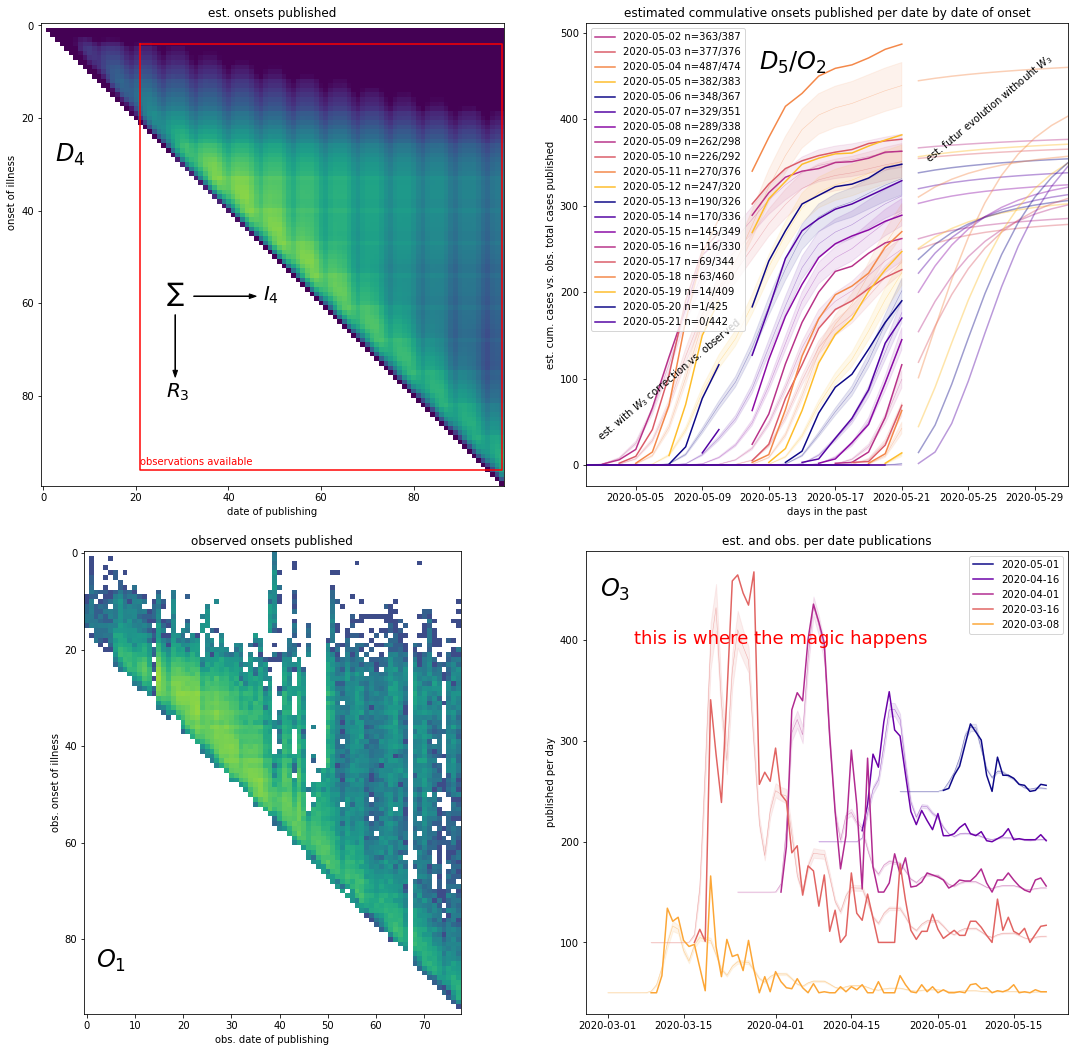

In [32]:
def Checker(ax,bx,ox,cx):
    ax.set_title("est. onsets published")
    
    pdc_dt = np.mean(trace.per_day_curve_dt,axis=0)
    mit = np.mean(trace.infected_t,axis=0)
    
    p = np.log(pdc_dt)
    
    ax.imshow(p,vmin=np.log(0.1),vmax=np.log(2000))
    dy,dx = onsets_per_date_diff.shape
    ax.plot([pfront,pfront,pfront+dx,pfront+dx,pfront],[ofront,dy,dy,ofront,ofront],color="red")
    ax.text(pfront,ofront+dy-5,"observations available",color="red")
    ax.set_xlabel("date of publishing")
    ax.set_ylabel(" "*40+"onset of illness")
    ax.text(.03,.7,r"$D_4$",transform=ax.transAxes,fontsize=24)
    
    ax.text(.27,.4,r"$\sum$",transform=ax.transAxes,fontsize=18)
    ax.text(.48,.4,r"$I_4$",transform=ax.transAxes,fontsize=20)
    ax.text(.27,.19,r"$R_3$",transform=ax.transAxes,fontsize=20)
    ax.arrow(.33,.41,.12,0,head_width=.01,transform=ax.transAxes,color="black")
    ax.arrow(.29,.37,0,-.12,head_width=.01,transform=ax.transAxes,color="black")
    
    bx.set_title("estimated commulative onsets published per date by date of onset")
    n = 20
    nob,nd = onsets_per_date.shape[1],onsets_per_date.shape[0]
    cs,cs2 = np.cumsum(trace.per_day_curve_dt,axis=2),np.cumsum(trace.per_day_curve_t,axis=2)
    ts_after = pd.date_range(ts[-1], periods=11, freq='D')

    for i in range(cs.shape[1]-n,cs.shape[1]):
#        c = plasma(1-(cs.shape[1]-i)/(n+1))
        c = plasma((i%7)/7)
        bx.plot(ts,np.mean(cs[:,i],axis=0),color=c,alpha=.4,linewidth=.5)
        bx.fill_between(ts,*np.percentile(cs[:,i],axis=0,q=(2.5,97.5)),color=c,alpha=.1)
        bx.plot(ts_after[1:],np.mean(cs2[:,i,model.length:model.length+10],axis=0),color=c,alpha=.4)
        
        if i-ofront < onsets_per_date.shape[0]:
            repo = onsets_per_date[i-ofront,-1]
            try:
                repoi = int(repo)
            except:
                repo = 0
            bx.plot(ts[pfront:pfront+onsets_per_date.shape[1]],onsets_per_date[i-ofront],color=c,label=sdt(ts[i])+" n=%d/%d"%(repo,np.mean(trace.reported_onset_of_illness_t[:,i],axis=0)))
    bx.set_ylabel("est. cum. cases vs. obs. total cases published")
    bx.set_xlabel("days in the past")
    bx.legend(loc=2)
    bx.text(.7,.7,"est. futur evolution withouht $W_3$",rotation=40,transform=bx.transAxes)
    bx.text(.02,.1,"est. with $W_3$ correction vs. observed",rotation=40,transform=bx.transAxes)

    bx.text(.36,.9,r"$D_5 / O_2$",transform=bx.transAxes,fontsize=24)
    
    print(bx.get_xticklabels())
    xlabels = bx.get_xticklabels()
#    bx.set_xticklabels(rotation=45)
    bx.set_xlim(ts[-20],ts_after[-1])

    
    cx.text(.03,.9,r"$O_3$",transform=cx.transAxes,fontsize=24)
    cx.set_ylabel("published per day")
    cx.set_title("est. and obs. per date publications")
    print(onsets_per_date_diff.shape)
    ds = [datetime.date(2020,5,1),datetime.date(2020,4,16),datetime.date(2020,4,1),datetime.date(2020,3,16),datetime.date(2020,3,8)]
    pdd,pdp = np.mean(trace.per_day_curve_dt,axis=0),np.percentile(trace.per_day_curve_dt,axis=0,q=(2.5,97.5))
    for i,d in enumerate(ds):
        ni = len(ds)-i
        c = plasma(i/(len(ds)*1.))
        j = (d-model.startdate).days
        cx.plot(ts[j+1:pfront+onsets_per_date_diff.shape[1]+1],ni*50+onsets_per_date_diff[j-ofront,j-pfront:],color=c,label=sdt(d))
        cx.plot(ts[j-7:],ni*50+pdd[j,j-7:],color=c,alpha=.5,linewidth=.5)
        cx.fill_between(ts[j-7:],*pdp[:,j,j-7:]+ni*50,color=c,alpha=.1)

    cx.text(.1,.8,"this is where the magic happens",fontsize=18,color="red",transform=cx.transAxes)
    cx.legend()
    
    po = np.log(onsets_per_date_diff)#/onsets_per_date[-1,1:].filled(1))
    ox.imshow(po,vmin=np.log(0.1),vmax=np.log(2000))
    ox.set_title("observed onsets published",fontsize=12)
    ox.set_xlabel("obs. date of publishing")
    ox.set_ylabel("obs. onset of illness")
    ox.text(.03,.1,r"$O_1$",transform=ox.transAxes,fontsize=24)
    
fig, a = plt.subplots(2, 2, figsize = (16,16),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.08,right=0.98,top=0.96,bottom=0.1)

Checker(a[0,0],a[0,1],a[1,0],a[1,1])
fig.savefig("test.pdf")

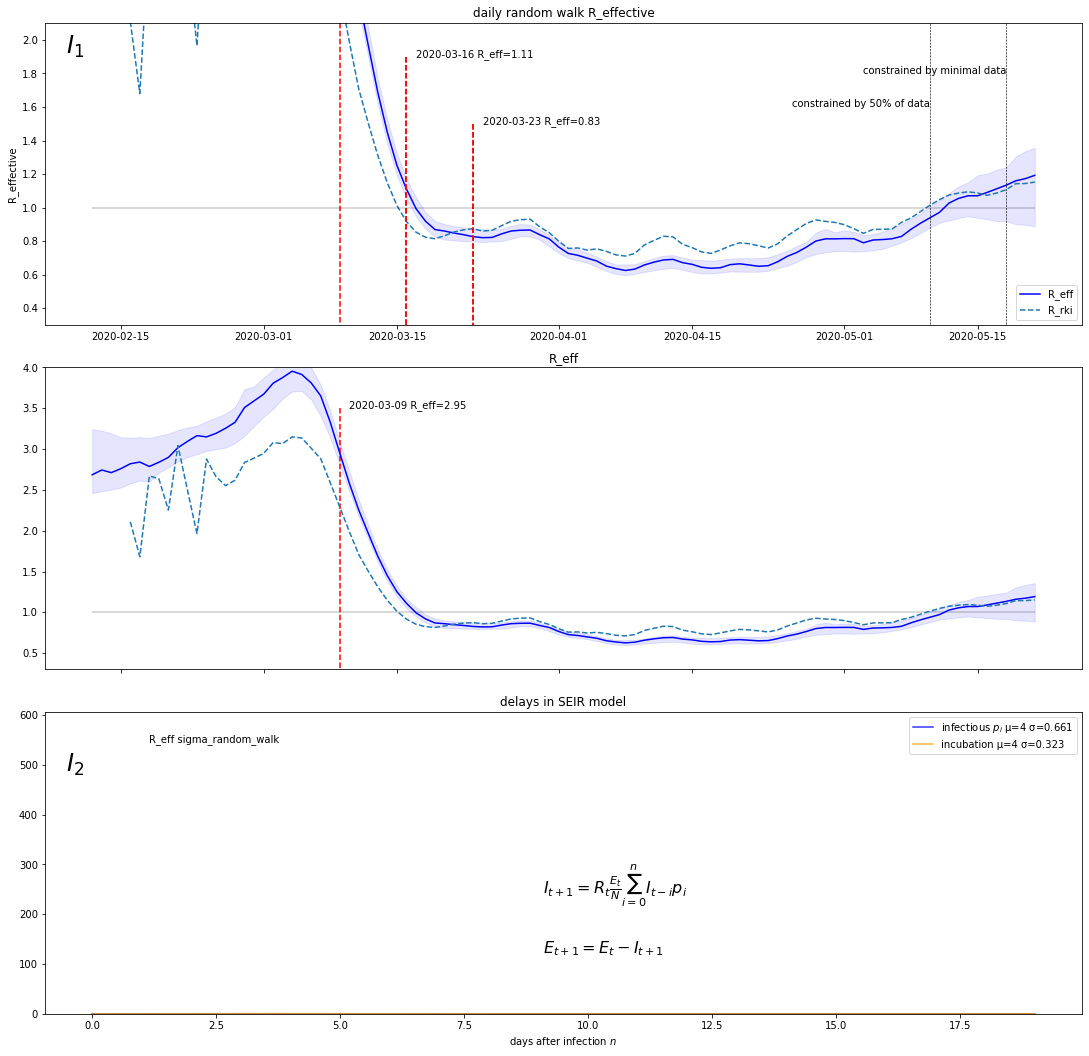

In [40]:
def R_eff(ax,cx,dx,h1):
    lambda_tm = np.mean(trace.lambda_t,axis=0)

    ax.fill_between(ts,*np.percentile(trace.lambda_t, axis=0, q=(2.5,97.5)),color="blue",alpha=.1)
    ax.plot(ts,lambda_tm,color="blue",label="R_eff")
    
    R_rki = trace.infected_t[:,4:] / trace.infected_t[:,:-4]
    R_rki_m = np.mean(R_rki,axis=0)
    
    ax.plot(ts[4:],R_rki_m,"--",label="R_rki")
 #   ax.fill_between(ts[4:],*np.percentile(R_rki,axis=0,q=(2.5,97.5)),alpha=.1)

    for d,y,bx in zip([datetime.date(2020,3,16),datetime.date(2020,3,23),datetime.date(2020,3,9)],[1.9,1.5,3.5],[ax,ax,cx]):
        ax.plot([d]*2,[y,0],"--",color="red")
        bx.plot([d]*2,[y,0],"--",color="red")
        bx.text(d+datetime.timedelta(days=1),y,sdt(d)+" R_eff=%.2f"%lambda_tm[(d-model.startdate).days])
    ax.set_ylabel("R_effective")
    
    ax.plot([ts[0],ts[-1]],[1,1],linewidth=.3,color="black")
    ax.legend(loc=4)
    ax.set_ylim(0.3,2.1)
    ax.set_title("daily random walk R_effective")#, R_0 = %.4f±%.4f"%())
    ax.text(.02,.9,r"$I_1$",transform=ax.transAxes,fontsize=24)
    
    cd = pfront+onsets_per_date.shape[1]-4
    cd50 = cd-8
    ax.plot([ts[cd]]*2,[0,4],"--",color="black",linewidth=.6)
    ax.text(ts[cd],1.8,"constrained by minimal data",horizontalalignment='right')
    ax.plot([ts[cd50]]*2,[0,4],"--",color="black",linewidth=.6)
    ax.text(ts[cd50],1.6,"constrained by 50% of data",horizontalalignment='right')
    
    cx.set_title("R_eff")
    cx.fill_between(ts,*np.percentile(trace.lambda_t, axis=0, q=(2.5,97.5)),color="blue",alpha=.1)
    cx.plot([ts[0],ts[-1]],[1,1],linewidth=.3,color="black")
    cx.plot(ts,lambda_tm,color="blue")
    cx.plot(ts[4:],R_rki_m,"--")
    cx.set_xticklabels([],rotation=20,horizontalalignment='right')
    cx.set_ylim(.3,4)
    
    x = np.arange(20)
    sinf,sinc = [],[]
    for s1,s2 in zip(trace.sigma_incubation,trace.sigma_infectious):
        sinc.append(f_beta(x,4,s1)[0])
        sinf.append(f_beta(x,4,s2)[0])
    sinf,sinc = np.array(sinf),np.array(sinc)
    
   # dx.plot(x,f_beta(x,4,1.3)[0],label=r"infectious $p_i$")
   # dx.plot(x,f_beta(x,4,.03)[0],label="incubation")
    dx.plot(x,np.mean(sinf,axis=0),label=r"infectious $p_i$ µ=4 σ=%.3f"%(np.mean(trace.sigma_infectious,axis=0)),color="blue",alpha=.8)
    dx.plot(x,np.mean(sinc,axis=0),label=r"incubation µ=4 σ=%.3f"%(np.mean(trace.sigma_incubation,axis=0)),color="orange",alpha=.8)
    dx.fill_between(x,*np.percentile(sinf,axis=0,q=(2.5,97.5)),color="blue",alpha=.1)
    dx.fill_between(x,*np.percentile(sinc,axis=0,q=(2.5,97.5)),color="orange",alpha=.1)
    
    dx.set_title("delays in SEIR model")
    dx.legend()
    dx.set_ylabel("")
    dx.set_xlabel(r"days after infection $n$")
    dx.text(.02,.8,r"$I_2$",transform=dx.transAxes,fontsize=24)
    dx.text(.48,.4,r"$I_{t+1}=R_t \frac{E_t}{N}\sum_{i=0}^{n}I_{t-i} p_i$",transform=dx.transAxes,fontsize=16)
    dx.text(.48,.2,r"$E_{t+1}=E_t-I_{t+1}$",transform=dx.transAxes,fontsize=16)
    
    h1.text(.1,.9,"R_eff sigma_random_walk",transform=h1.transAxes)
    h1.hist(trace.lambda_t_sigma_random_walk,alpha=.8)
    
fig, a = plt.subplots(3, 1, figsize = (16,16),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.08,right=0.98,top=0.96,bottom=0.1)

R_eff(a[0,0],a[1,0],a[2,0],a[2,0])
fig.savefig("test2.pdf")

363.0 363
377.0 377
487.0 487
382.0 382
348.0 348
329.0 329
289.0 289
262.0 262
226.0 226
270.0 270
247.0 247
190.0 190
170.0 170
145.0 145
116.0 116
69.0 69
63.0 63
14.0 14
1.0 1
<a list of 8 Text major ticklabel objects>
(96, 78)
Bbox(x0=0.05, y0=0.05000000000000038, x1=0.6566274509803921, y1=0.1974671532846718)


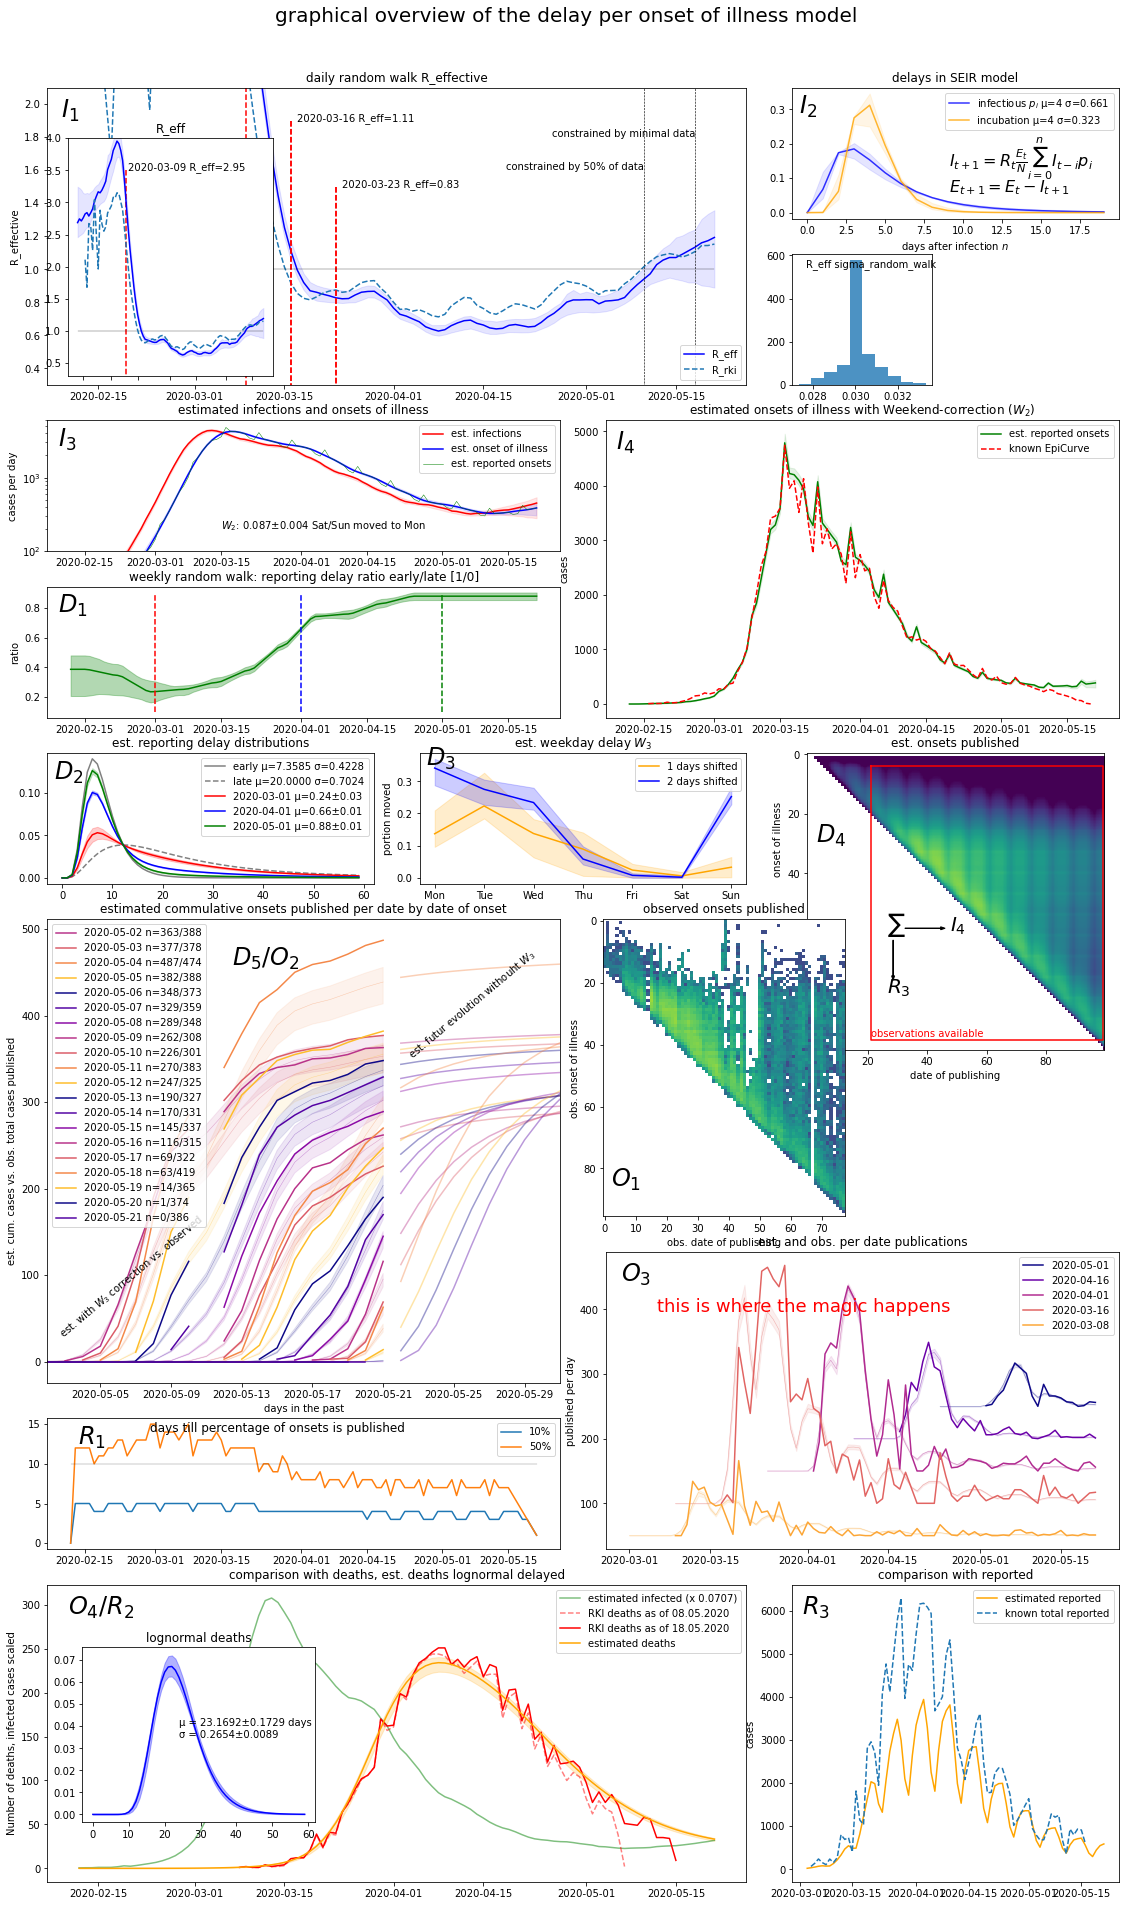

In [41]:
ts = pd.date_range(model.startdate, periods=len(trace.lambda_t[0]), freq='D')

plasma = plt.cm.plasma
publishing_start = datetime.date(2020,3,4)  # Startdate of epicurves
onset_start = datetime.date(2020,2,16)    # Startdate of known onsets
ofront = (onset_start-model.startdate).days
pfront = (publishing_start-model.startdate).days

def sdt(dt):
    return ("%s"%(dt))[:10]
#return ("%s %s"%(["mo","tu","we","th","fr","sa","so"][dt.weekday()],dt))[:15]

    
def Infected(ax,bx):
    ax.semilogy(ts,np.mean(trace.infected_t,axis=0),color="red",label="est. infections")
    ax.fill_between(ts,*np.percentile(trace.infected_t,axis=0,q=(2.5,97.5)),alpha=.1,color="red")

    ax.semilogy(ts,np.mean(trace.onset_of_illness_t,axis=0),color="blue",label="est. onset of illness")
    ax.semilogy(ts,np.mean(trace.reported_onset_of_illness_t,axis=0),color="green",label="est. reported onsets",linewidth=.5)
    ax.fill_between(ts,*np.percentile(trace.onset_of_illness_t,axis=0,q=(2.5,97.5)),alpha=.1,color="blue")
    ax.set_ylabel("cases per day")
    ax.set_ylim(100,6000)
    ax.legend()
    ax.set_title("estimated infections and onsets of illness")
    ax.text(datetime.date(2020,3,15),200,r"$W_2$: %.3f±%.3f Sat/Sun moved to Mon"%(np.mean(trace.w_trans,axis=0),np.std(trace.w_trans,axis=0)))
    ax.text(.02,.8,r"$I_3$",transform=ax.transAxes,fontsize=24)
    
    epi_curve = onsets_per_date[:,-1]
    bx.plot(ts,np.mean(trace.reported_onset_of_illness_t,axis=0),color="green",label="est. reported onsets")
    bx.fill_between(ts,*np.percentile(trace.reported_onset_of_illness_t,axis=0,q=(2.5,97.5)),alpha=.1,color="green")
    bx.plot(ts[4:len(epi_curve)+4],epi_curve,"--",color="red",label="known EpiCurve")
#    bx.plot(ts,np.mean(np.sum(trace.per_day_curve_dt,axis=1),axis=0)[:len(ts)],"-",color="orange",label="estimated reported")
  #  reported = [66,138,239,156,107,237,157,271,802,693,733,400,1817,1144,1036,2807,2958,2705,1948,4062,4764,4118,4954,5780,6294,3965,4751,4615,5453,6156,6174,6082,5936,3677,3834,4003,4974,5323,4133,2821,2537,2082,2486,2866,3380,3609,2458,1775,1785,2237,2352,2337,2055,1737,1018,1144,1304,1478,1639,945,793,679,685,947,1284,1209,1251,667,357,933,798,933,913,620]
  #  reported = ma.masked_less(reported,0.,copy=True)
  #  bx.plot(pd.date_range(datetime.date(2020,3,4),periods=len(reported),freq='D'),reported,"--",label="known total reported")
    bx.legend()
    bx.set_ylabel("cases")
    bx.set_title(r"estimated onsets of illness with Weekend-correction ($W_2$)")
    bx.text(.02,.9,r"$I_4$",transform=bx.transAxes,fontsize=24)

def ReportedDelay(ax,bx,cx):
    da = [datetime.date(2020,3,1),datetime.date(2020,4,1),datetime.date(2020,5,1)]
    
    ax.plot(ts,np.mean(trace.delay_ratio_t,axis=0),color="green",label="ratio")
    ax.fill_between(ts,*np.percentile(trace.delay_ratio_t,axis=0,q=(2.5,97.5)),alpha=.3,color="green")
    
    ax.set_title("weekly random walk: reporting delay ratio early/late [1/0]")
    ax.set_ylabel("ratio")
    ax.text(.02,.8,r"$D_1$",transform=ax.transAxes,fontsize=24)
    
    x = np.arange(60)
    r_delay1,r_delay2 = [],[]
    for m1,s1,m2,s2 in zip(trace.delay_m1,trace.delay_s1,[20]*len(trace.delay_m1),trace.delay_s2):
        r_delay1.append(f_beta(x,m1,s1)[0])
        r_delay2.append(f_beta(x,m2,s2)[0])
    r_delay1,r_delay2 = np.array(r_delay1,dtype=np.float64),np.array(r_delay2,dtype=np.float64)
    
    m2 = 20
    try:
        m2 =(np.mean(trace.delay_m2,axis=0))
    except:
        pass
    
    r = (np.mean(trace.delay_m1,axis=0),np.mean(trace.delay_s1,axis=0),)
    bx.plot(x,np.mean(r_delay1,axis=0),label="early µ=%.4f σ=%.4f"%r,color="grey")
    bx.plot(x,np.mean(r_delay2,axis=0),"--",label="late µ=%.4f σ=%.4f"%(m2,np.mean(trace.delay_s2,axis=0)),color="grey")
    for d,c in zip(da,["red","blue","green"]):
        i = (d-model.startdate).days
        ax.plot([ts[i]]*2,[.1,.9],"--",color=c)
        dlf = ( r_delay1.T*trace.delay_ratio_t[:,i]+r_delay2.T*(1-trace.delay_ratio_t[:,i]) ).T
        bx.plot(x,np.mean(dlf,axis=0),color=c,label=sdt(ts[i])+" µ=%.2f±%.2f"%(np.mean(trace.delay_ratio_t[:,i]),np.std(trace.delay_ratio_t[:,i])))
        bx.fill_between(x,*np.percentile(dlf,axis=0,q=(2.5,97.5)),color=c,alpha=.2)
    bx.set_title("est. reporting delay distributions")
    bx.legend()
    bx.text(.02,.8,r"$D_2$",transform=bx.transAxes,fontsize=24)
    
    cx.set_title(r"est. weekday delay $W_3$")
    try:
        for i,c in zip(range(trace.d_factor.shape[1]),["orange","blue","green"]):
            cx.plot(np.mean(trace.d_factor[:,i],axis=0),label="%d days shifted"%(i+1),color=c)
            cx.fill_between(range(7),*np.percentile(trace.d_factor[:,i],axis=0,q=(2.5,97.5)),color=c,alpha=.2)
    except:
        pass
    cx.set_ylabel("portion moved")
    cx.set_xticklabels(["","Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
    cx.legend()
    cx.text(.02,.9,r"$D_3$",transform=cx.transAxes,fontsize=24)
    


def Results(bx,ax,cx,dx):
    deaths = [1, 2, 1, 1, 4, 2, 3, 4, 11, 12, 12, 21, 39, 24, 41, 40, 64, 75, 90, 102, 106, 115, 170, 162, 163, 199, 195, 220, 234, 239, 246, 251, 251, 232, 238, 229, 237, 241, 218, 232, 229, 180, 203, 204, 168, 187, 147, 155, 121, 140, 119, 120, 122, 115, 98, 75, 87, 75, 84, 72, 51, 50, 49, 58, 56, 35, 35, 34, 9]
    deaths = np.asarray(deaths,dtype=np.float64)
    deaths_200508 = [1, 2, 1, 1, 3, 2, 2, 3, 10, 12, 12, 20, 38, 23, 39, 38, 64, 74, 87, 101, 106, 115, 170, 157, 161, 199, 192, 218, 232, 238, 244, 244, 242, 233, 232, 222, 229, 236, 219, 221, 221, 171, 195, 200, 159, 177, 136, 152, 116, 129, 114, 100, 109, 104, 80, 62, 77, 68, 64, 38, 2]
    death_start = datetime.date(2020,3,8)
    deaths_200508 = np.asarray(deaths_200508,dtype=np.float64)
    td = pd.date_range(death_start,periods=len(deaths),freq='D')

    f_death = np.mean(trace.f_death,axis=0)
    bx.plot(ts[:len(trace.infected_t[0])],np.mean(trace.infected_t,axis=0)*f_death,color="green",alpha=.5,label="estimated infected (x %.4f)"%f_death)
    bx.plot(td[:len(deaths_200508)],deaths_200508,"--",label="RKI deaths as of 08.05.2020",color="red",alpha=.5)
    bx.plot(td,deaths,label="RKI deaths as of 18.05.2020",color="red")
    bx.plot(ts,np.mean(trace.dead_t,axis=0)[:len(ts)],color="orange",label="estimated deaths")
    bx.fill_between(ts,*np.percentile(trace.dead_t[:,:len(ts)],axis=0,q=(2.5,97.5)),color="orange",alpha=.2)
    bx.set_ylabel("Number of deaths, infected cases scaled")
    bx.legend()
    bx.set_title("comparison with deaths, est. deaths lognormal delayed")
    bx.text(.03,.9,r"$O_4 / R_2$",transform=bx.transAxes,fontsize=24)
    
    ax.plot(ts[20:],np.mean(np.sum(trace.per_day_curve_dt,axis=1),axis=0)[20:len(ts)],"-",color="orange",label="estimated reported")
#    ax.plot(ts[20:],np.mean(np.sum(trace.per_day_curve_total_dt,axis=1),axis=0)[20:len(ts)],"-",color="orange",label="estimated reported")

    reported = [66,138,239,156,107,237,157,271,802,693,733,400,1817,1144,1036,2807,2958,2705,1948,4062,4764,4118,4954,5780,6294,3965,4751,4615,5453,6156,6174,6082,5936,3677,3834,4003,4974,5323,4133,2821,2537,2082,2486,2866,3380,3609,2458,1775,1785,2237,2352,2337,2055,1737,1018,1144,1304,1478,1639,945,793,679,685,947,1284,1209,1251,667,357,933,798,933,913,620]
    reported = ma.masked_less(reported,0.,copy=True)
    ax.plot(pd.date_range(datetime.date(2020,3,4),periods=len(reported),freq='D'),reported,"--",label="known total reported")
    ax.legend()
    ax.set_ylabel("cases")
    ax.text(.03,.9,r"$R_3$",transform=ax.transAxes,fontsize=24)
    ax.set_title("comparison with reported")
    
    dists = []
    x = np.arange(0,60,dtype=np.float64)
    for d,s in zip(trace.m_death,trace.s_death):
        dists.append(f_beta(x,d,s)[0])
    dists = np.array(dists)
    mdv,mds = np.mean(trace.m_death,axis=0),np.std(trace.m_death,axis=0)
    msv,mss = np.mean(trace.s_death,axis=0),np.std(trace.s_death,axis=0)

    cx.plot(x,np.mean(dists,axis=0),color="blue",label="Distribution of deaths estimated")
    cx.fill_between(x,*np.percentile(dists,axis=0,q=(2.5,97.5)),alpha=.3,color="blue")
  #  cx.text(45,.045,"Lognormal distribution")
    cx.text(24,.04,"µ = %.4f±%.4f days"%(mdv,mds))
    cx.text(24,.035,"σ = %.4f±%.4f"%(msv,mss))
#    cx.set_ylabel("probability of death on that day")
  #  cx.set_xlabel("days after date of infection")
    #cx.set_xticklabels([],rotation=20,horizontalalignment='right')
    cx.set_title("lognormal deaths")
    
#    dx.set_title("observed reporting delay")
    py = {10:[0]*len(ts),50:[0]*len(ts),90:[0]*len(ts)}
    dc = np.cumsum(np.mean(trace.per_day_curve_dt,axis=0),axis=1)
    m = np.mean(trace.onset_of_illness_t,axis=0)
    for i in range(len(ts)):
        d = dc[i]
        for j,dj in enumerate(d):
            if dj < m[i]*.1:
                py[10][i] = j-i+1
            if dj < m[i]*.5:
                py[50][i] = j-i+1
            if dj < m[i]*.9:
                py[90][i] = j-i+1
    dx.plot(ts,py[10],label="10%")
    dx.plot(ts,py[50],label="50%")
#    dx.plot(ts,py[90],label="90%")
    dx.legend()
    dx.text(.2,.9,"days till percentage of onsets is published",transform=dx.transAxes,fontsize=12)
    
    
    dx.plot([ts[0],ts[-1]],[10,10],linewidth=.2,color="black")
    dx.text(.06,.8,r"$R_1$",transform=dx.transAxes,fontsize=24)
    
fig = plt.figure(figsize=(16,28))
fig.subplots_adjust(wspace=0.33,hspace=0.27,left=0.05,right=0.98,top=0.94,bottom=0.05)
fig.suptitle("graphical overview of the delay per onset of illness model",fontsize=20)
gs = fig.add_gridspec(11, 6)

# R_effective
ax = fig.add_subplot(gs[0:2,0:4]) 
dx = fig.add_subplot(gs[0,4:6])

axp = ax.get_position()
cx = fig.add_axes([axp.x0+(axp.x1-axp.x0)*.03,axp.y0+(axp.y1-axp.y0)*.03,axp.x0+(axp.x1-axp.x0)*.21,(axp.y1-axp.y0)*.8])
h1 = fig.add_subplot(gs[1,4])
R_eff(ax,cx,dx,h1)

# Infections
i1x,i2x = fig.add_subplot(gs[2:3,0:3]),fig.add_subplot(gs[2:4,3:6])
Infected(i1x,i2x)

# Reporting delay
rx = fig.add_subplot(gs[3,0:3])
dx = fig.add_subplot(gs[4,0:2])
wx = fig.add_subplot(gs[4,2:4])
ReportedDelay(rx,dx,wx)

# infected convolved Reporting delays
xx = fig.add_subplot(gs[4:6,4:6])
x2 = fig.add_subplot(gs[5:8,0:3])
x3 = fig.add_subplot(gs[7:9,3:6])
ox = fig.add_subplot(gs[5:7,3:4])
oxp = ox.get_position()
ox.set_position([oxp.x0*.97,oxp.y0,(oxp.x1-oxp.x0)*1.95,oxp.y1-oxp.y0])
Checker(xx,x2,ox,x3)

# Results
r1 = fig.add_subplot(gs[9:11,:4])
r2 = fig.add_subplot(gs[9:11,4:])
rxp = r1.get_position()
print(rxp)
r3 = fig.add_axes([rxp.x0+(rxp.x1-rxp.x0)/20.,rxp.y0+(rxp.y1-rxp.y0)/5,(rxp.x1-rxp.x0)/3,(rxp.y1-rxp.y0)/1.7])
r4 = fig.add_subplot(gs[8,:3])
Results(r1,r2,r3,r4)


fig.savefig("Overview.pdf")

In [ ]:
ts = pd.date_range(model.startdate,periods=model.length,freq='D')
#epi_curve = datasets.datasets["epi_curve"].dataset
epi_curve = onsets_per_date[:,-1]

fig, axes = plt.subplots(3, 1, figsize = (12,12),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.08,right=0.98,top=0.96,bottom=0.05)
fig.suptitle("SEIR Model observation = onset-reporting-Matrix")

ax = axes[0,0]

ax.semilogy(ts,np.mean(trace.infected_t,axis=0),color="red",label="estimated new infections")
ax.fill_between(ts,*np.percentile(trace.infected_t,axis=0,q=(2.5,97.5)),alpha=.1,color="red")

ax.semilogy(ts,np.mean(trace.onset_of_illness_t,axis=0),color="blue",label="est onset of illness")
ax.semilogy(ts,np.mean(trace.reported_onset_of_illness_t,axis=0),color="green",label="est. reported onset with weekend-effect",linewidth=.5)
ax.fill_between(ts,*np.percentile(trace.onset_of_illness_t,axis=0,q=(2.5,97.5)),alpha=.1,color="blue")
ax.set_ylabel("cases")
ax.set_ylim(100,6000)
ax.legend()

a2x = axes[1,0]
a2x.plot(ts,np.mean(trace.reported_onset_of_illness_t,axis=0),color="green",label="estimated reported onset")
a2x.fill_between(ts,*np.percentile(trace.reported_onset_of_illness_t,axis=0,q=(2.5,97.5)),alpha=.1,color="green")
a2x.plot(ts[4:len(epi_curve)+4],epi_curve,"--",color="red",label="known EpiCurve")
#a2x.plot(ts,np.mean(np.sum(trace.per_day_curve_dt,axis=1),axis=0)[:len(ts)],"-",color="orange",label="estimated reported")
reported = [66,138,239,156,107,237,157,271,802,693,733,400,1817,1144,1036,2807,2958,2705,1948,4062,4764,4118,4954,5780,6294,3965,4751,4615,5453,6156,6174,6082,5936,3677,3834,4003,4974,5323,4133,2821,2537,2082,2486,2866,3380,3609,2458,1775,1785,2237,2352,2337,2055,1737,1018,1144,1304,1478,1639,945,793,679,685,947,1284,1209,1251,667,357,933,798,933,913,620]
reported = ma.masked_less(reported,0.,copy=True)
#a2x.plot(pd.date_range(datetime.date(2020,3,4),periods=len(reported),freq='D'),reported,"--",label="known total reported")
a2x.legend()
a2x.set_ylabel("cases")

bx = axes[2,0]
lambda_tm = np.mean(trace.lambda_t,axis=0)

bx.fill_between(ts,*np.percentile(trace.lambda_t, axis=0, q=(2.5,97.5)),color="blue",alpha=.1)
bx.plot(ts,lambda_tm,color="blue",label="R_eff")
#for i in [33,99,176]:
 #   bx.plot(ts,trace.lambda_t[i],linewidth=.5,alpha=.6)

lockdown = datetime.date(2020,3,16)
bx.plot([lockdown]*2,[4,0],"--",color="red")
bx.text(lockdown+datetime.timedelta(days=1),1.9,"16.03.2020 R_eff=%.2f"%lambda_tm[(lockdown-model.startdate).days])
bx.set_ylabel("R_eff")

easter = datetime.date(2020,4,12)
bx.plot([easter]*2,[4,0],"--",color="blue")
bx.text(easter+datetime.timedelta(days=1),1.9,"easter sunday R_eff=%.2f"%lambda_tm[(easter-model.startdate).days])
bx.plot([ts[0],ts[-1]],[1,1],linewidth=.3,color="black")

last = pfront + onsets_per_date_diff.shape[1]-5
bx.plot([ts[last]]*2,[4,0],"--",color="black")
bx.text([ts[last+2]],.75,"R_eff unconstraint by data",rotation=90,fontsize=12,color="red")
bx.plot([ts[last-8]]*2,[4,0],"--",color="black")
bx.text([ts[last-6]],.75,"< 50% of data reported",rotation=90,fontsize=12,color="red")

#bx.plot((ts[7::7]-datetime.timedelta(days=model.weekoffset)),np.mean(trace.lambda_t_random_walk,axis=0)[1:]+np.mean(trace.lambda_0),"o",color="red",label="weekly random walk")
bx.legend(loc=4)
bx.set_ylim(0.25,2.1)

cx = fig.add_axes([.11,.07,.24,.24])
cx.set_title("R_eff")
cx.fill_between(ts,*np.percentile(trace.lambda_t, axis=0, q=(2.5,97.5)),color="blue",alpha=.1)
cx.plot([ts[0],ts[-1]],[1,1],linewidth=.3,color="black")
cx.plot(ts,lambda_tm,color="blue")

#cx.plot(ta[:len(trace.lambda_t[0])],np.median(trace.lambda_t,axis=0))
#cx.fill_between(ta[:len(trace.lambda_t[0])],*np.percentile(trace.lambda_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
#cx.set_xticks(dtx)
_ = cx.set_xticklabels([],rotation=20,horizontalalignment='right')

plt.savefig("ReportingDelyWithWeekendEffekts123.svg")
plt.savefig("ReportingDelyWithWeekendEffekts.pdf")

In [ ]:
ta = pd.date_range(datetime.date(2020,2,12), periods=120, freq='D')

fig, axes = plt.subplots(1,1 , figsize = (10,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.05,right=0.98,top=0.96,bottom=0.05)
ax = axes[0,0]


pdd = np.mean(trace.per_day_curve_t,axis=0)
#pdc,pdcs = np.cumsum(pdd,axis=1),np.percentile(trace.per_day_curve_s,axis=0,q=(2.5,97.5))

m =np.mean(trace.reported_onset_of_illness_t,axis=0)
start = 70
for i in range(start,model.length-2):
    c = plasma((i-start)/(model.length-start))
#    ax.plot(range(-25,20),pdc[i][65:110],label=("%s new=%d")%(("%s"%ta[i])[:10],m[i]),color=c,alpha=.5)
 #   ax.fill_between(range(-29,2),*pdcs[:,i,40:],color=c,alpha=.1)
    ax.plot(range(-32,4),onsets_per_date[i-4][40:],color=c)
    
ax.legend()



## single Case Overview

| time | event | distribution | RKI |
|------|-------|--------------|-----|
| -4 | infected | |
| -2... | infectious | lognormal | 
| 0...2 | onset of illness | | RefDate |
| +x | tested | | Meldedatum |
| x+y | reported to RKI | | first appearence in DB |

* number of RefDate is epidemic curve (EpiCurve), i.e. number with cases of onset of illness known on a given date
* numner of infections on a date is roughly EpiCurve shifted forward 4-5 days
* Reported Meldedatum not the date, the data appears in the RKI-Dataset, but Meldung to lower-level-authorities


## Model overview
* intial distribution of imported cases
* weekly priors for R_eff and delay_ratio, smoothed (3 day window/linear interpolation)
* model reporting-delay i.e. time till case appears in RKI-database
* for each day, generate distribution, when cases appear as 'onset known' in RKI-database
* observation: for each date: vector of 'onset knwon' by date they appear in RKI-database
* Hope is to estimate current reporting-delay
* side project: delay cases to generate death/day

**Only models based on known onsets of illness!**


In [ ]:
dtx = [datetime.date(2020,3,1),datetime.date(2020,3,15),datetime.date(2020,4,1),datetime.date(2020,4,15),datetime.date(2020,5,1)]
dtx += [datetime.date(2020,5,15)]

epi_curve = [7, 9, 8, 10, 33, 19, 26, 45, 64, 102, 147, 158, 197, 179, 195, 272, 258, 350, 366, 585, 747, 997, 1521, 1944, 2421, 2672, 3272, 3282, 3422, 4546, 3778, 3929, 3376, 3964, 3220, 2659, 3822, 2826, 3069, 2737, 2798, 2644, 2144, 2999, 2210, 2597, 2332, 2384, 1886, 1683, 2165, 1835, 1689, 1635, 1342, 1154, 1171, 1122, 1152, 1090, 959, 919, 819, 689, 874, 681, 641, 634, 564, 460, 402, 516, 370, 310, 274, 158, 125, 104, 69, 11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
epi_curve = np.array(epi_curve,dtype=np.float64)
rki_reported = [0,138,239,156,107,237,157,271,802,693,733,400,1817,1144,1036,2807,2958,2705,1948,4062,4764,4118,4954,5780,6294,3965,4751,4615,5453,6156,6174,6082,5936,3677,3834,4003,4974,5323,4133,2821,2537,2082,2486,2866,3380,3609,2458,1775,1785,2237,2352,2337,2055,1737,1018,1144,1304,1478,1639,945,793,679,685,947,1284,1209,64,97,130,209,223,262]
rki_reported = np.array(rki_reported)
deaths = [-1]*17+[-1,-1,-1,-1,-1,-1,0,1,2,0,3,4,0,0,0,8,11,16,8,31,28,35,49,55,72,64,66,128,149,140,145,141,184,92,173,254,246,266,171,129,126,170,285,315,299,242,184,110,194,281,215,227,179,140,110,163,202,173,193,94,74,43,139,165]#deaths = [0]*4+deaths
deaths = np.asarray(deaths,dtype=np.float64)

fig, axes = plt.subplots(2, 1, figsize = (12,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.05,right=0.98,top=0.96,bottom=0.05)
fig.suptitle('Estimates for (known!) EpiCurve, hospitalization and deaths')
ax = axes[0,0]
bx = axes[1,0]
cx = fig.add_axes([.11,.15,.27,.27])

ax.plot(ta[:94],np.median(trace.infected_t,axis=0),color="red",alpha=.5,label="new_infected")
ax.plot(ta[4:94+4],np.median(trace.infected_t,axis=0),color="blue",alpha=.5,label="new_infected_shifted")
ax.fill_between(ta[:94],*np.percentile(trace.infected_t, axis=0, q=(12.5,87.5)),color="red",alpha=.1)

#ax.plot(ta[:83],np.median(trace.initial_t,axis=0),c="purple",label="Imported")
bx.plot(ta[:100],np.sum(np.mean(trace.per_day_curve_t,axis=0),axis=0)[:100],label="reported")
#ax.plot(ta[17:83],*(np.percentile(trace.per_day_curve_s,axis=0,q=(12.5,87.5))) )

ax.plot(ta[4:len(epi_curve)+4],epi_curve,"--",color="blue",label="EpiCurve")
bx.plot(ta[17+4:17+4+len(rki_reported)],rki_reported,"--",color="orange",label="reported")
rki_reported

ax.set_ylabel("cases per day")
ax.legend(loc=1)
ax.set_xticks(dtx)
ax.set_xticklabels(dtx)

if False:
    bx.plot(ta[:len(deaths)],deaths,color="red",label="deaths")
    bx.plot(ta[:94],np.median(trace.dead_t,axis=0),color="orange")
    bx.fill_between(ta[:83],*np.percentile(trace.dead_t, axis=0, q=(2.5,7.5)),color="orange",alpha=.2)

bx.set_ylabel("cases per day")
bx.legend(loc=1)
bx.set_xticks(dtx)
bx.set_xticklabels(dtx)

cx = fig.add_axes([.11,.15,.27,.27])
cx.set_title("R_eff")
#cx.plot(ta[:len(trace.lambda_t[0])],np.median(trace.lambda_t,axis=0))
#cx.fill_between(ta[:len(trace.lambda_t[0])],*np.percentile(trace.lambda_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
#cx.set_xticks(dtx)
#_ = cx.set_xticklabels(dtx,rotation=20,horizontalalignment='right')

In [ ]:
def tt_lognormal(x, mu, sigma):
    x = tt.clip(x,1e-12,1e12) # Checks to improve stability and resilience against NANs
    
    distr = 1/x* tt.exp(-((tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=0)+1e-9)

def reportDelayDist(x, mu1, sig1, mu2, sig2, r ):
    x = tt.clip(x,1e-12,1e12) # Checks to improve stability and resilience against NANs
    r = tt.clip(r,0,1)
    d1 = tt_lognormal(x,mu1,sig1)
    d2 = tt_lognormal(x,mu2,sig2)
    
    ds = r*d1 + (1-r)*d2
    
    return ds / (tt.sum(ds) + 1e-12)

ts = ta[:97]

v = ["delay_m1","delay_s1","delay_s2"]
for n in v:
    print(n,"%.2f %.3f"%(np.mean(trace[n],axis=0),np.std(trace[n],axis=0)))
print("delay_m2 fixed to %.3f"%20)

m1,m2,s1,s2 = np.mean(trace.delay_m1,axis=0),20,np.mean(trace.delay_s1,axis=0),np.mean(trace.delay_s2,axis=0)

fig, axes = plt.subplots(2, 1, figsize = (12,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.05,right=0.98,top=0.96,bottom=0.05)
ax = axes[0,0]
bx = axes[1,0]
dlr = np.mean(trace.delay_ratio_t,axis=0)
ax.plot(ts,dlr)
ax.fill_between(ts,*np.percentile(trace.delay_ratio_t,axis=0,q=(2.5,97.5)),alpha=.1)

ax.set_ylabel("ratio early to late")

py = {10:[0]*len(ts),50:[0]*len(ts),90:[0]*len(ts)}
for i in range(len(ts)):
    d = pdc[i]
    m = np.mean(trace.reported_onset_of_illness_t,axis=0)[i]
    for j,dj in enumerate(d):
        if dj < m*.1:
            py[10][i] = j-i+1
        if dj < m*.5:
            py[50][i] = j-i+1
        if dj < m*.9:
            py[90][i] = j-i+1

bx.plot([ts[0],ts[-1]],[10,10],linewidth=.2,color="black")
bx.plot(ts,py[10],label="10%")
bx.plot(ts,py[50],label="50%")
bx.plot(ts,py[90],label="90%")
bx.legend()

print("50 precent known after %d days after incubation"%py[50][-1])
#    print(dlr[i])
#    print(reportDelayDist(np.arange(60),m1,s1,m2,s2,dlr[i]))
#    bx.plot()

In [ ]:
print(trace.stat_names)
print(trace.tree_size)
print(trace.model_logp)

In [ ]:
for i in range(4):
    plt.plot(trace.lambda_t_random_walk[:,8+i])

In [ ]:
j = 50
print(ts[j],onsets_per_date_diff[j])

In [ ]:
def Move(data,factors):
    d_oeye = tt.roll(tt.eye(7),-offset,axis=1)
    week_mask = tt.tile(d_oeye,walk_len)[:,:n]

ts = pd.date_range(model.startdate,periods=model.length,freq='D')

publishing_start = datetime.date(2020,3,4)  # Startdate of epicurves
onset_start = datetime.date(2020,2,16)    # Startdate of known onsets
ofront = (onset_start-model.startdate).days
pfront = (publishing_start-model.startdate).days
    
    
pdt_t = np.mean(trace.per_day_curve_t,axis=0)
pdc_t = np.mean(trace.per_day_curve_dt,axis=0)
pdc_tp = np.percentile(trace.per_day_curve_dt,axis=0,q=(2.5,97.5))
pdc_m = np.array(pdc_t[:93,:])

opd = onsets_per_date_diff
print(model.length)
print(pdt_t.shape)
print(opd.shape)
print(ofront,pfront)

fig, axes = plt.subplots(2,1 , figsize = (10,12),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.05,right=0.98,top=0.96,bottom=0.05)
ax,bx = axes[0,0],axes[1,0]
plasma = plt.cm.plasma

#r = range(17,93,8)
r = range(15,93,7)
r = sorted(r)
for j,i in enumerate(r):
    c = plasma(j/(len(r)+1.))
    if True:
        ax.plot(ts[14:97],j*350+pdc_m[i,14:],color=c,alpha=.5)
        ax.plot(ts[14:97],j*350+pdt_t[i,14:97],"--",color=c,alpha=.5)
        ax.plot(ts[pfront:pfront+onsets_per_date_diff.shape[1]],j*350+onsets_per_date_diff[i-ofront+1],color=c)
        ax.plot([ts[i]]*2,[j*350,(j+1)*350],color="black")
        ax.text(ts[i-2],j*350+100,ts[i],ha="right")
    if True:
        bx.plot(ts[14:97],-j*350+np.cumsum(pdc_m[i,14:]),color=c,alpha=.5)
        bx.plot(ts[14:97],-j*350+np.cumsum(pdt_t[i,14:97]),"--",color=c,alpha=.5)
        bx.fill_between(ts[14:97],*((np.cumsum(pdc_tp,axis=2)[:,i]-j*350)[:,14:97]),color=c,alpha=.1 )
        #        ax.fill_between(ts[14:97],)

        
        bx.plot(ts[pfront:pfront+onsets_per_date.shape[1]],-j*350+onsets_per_date[i-ofront],color=c)
        bx.plot([ts[i]]*2,[-j*350,(-j+1)*350],color="black")
        bx.text(ts[i-2],-j*350+100,("%s"%ts[i])[:10],ha="right")

In [ ]:
print(np.mean(trace.d_factor,axis=0))

In [ ]:
print(onsets_per_date.shape)
print(onsets_per_date_diff.shape)
print(trace.per_day_curve_t.shape)
pdc = np.mean(trace.per_day_curve_t,axis=0)
print(pdc.shape)

In [ ]:
opd = onsets_per_date_diff
for i,c in zip([40,50,80],["blue","red","orange"]):

#    plt.plot(pdc[:90,i],color=c)
    plt.plot(pdc[i,:],"--",color=c)
    plt.plot(np.arange(len(opd[i]))+opd.shape[0]-opd.shape[1],opd[i],color=c)

In [ ]:
for i in range(20,30):
    print
    print(onsets_per_date[i,])
    print(onsets_per_date_diff[i])

In [ ]:
plt.plot(ts,np.mean(trace.coverage_t,axis=0))

In [ ]:
reported = [66,138,239,156,107,237,157,271,802,693,733,400,1817,1144,1036,2807,2958,2705,1948,4062,4764,4118,4954,5780,6294,3965,4751,4615,5453,6156,6174,6082,5936,3677,3834,4003,4974,5323,4133,2821,2537,2082,2486,2866,3380,3609,2458,1775,1785,2237,2352,2337,2055,1737,1018,1144,1304,1478,1639,945,793,679,685,947,1284,1209,1251,667,357,933,798,933,913,620]
#reported = ma.masked_less(reported,0.,copy=True)
offset = datetime.datetime(2020,3,4).weekday()

print(reported[(5-offset)::7])
for i in range(7):
    c = plasma(i/7.)
    rp = reported[7-offset+i::7]
    plt.plot(np.arange(len(rp))+i/7.,rp,color=c)

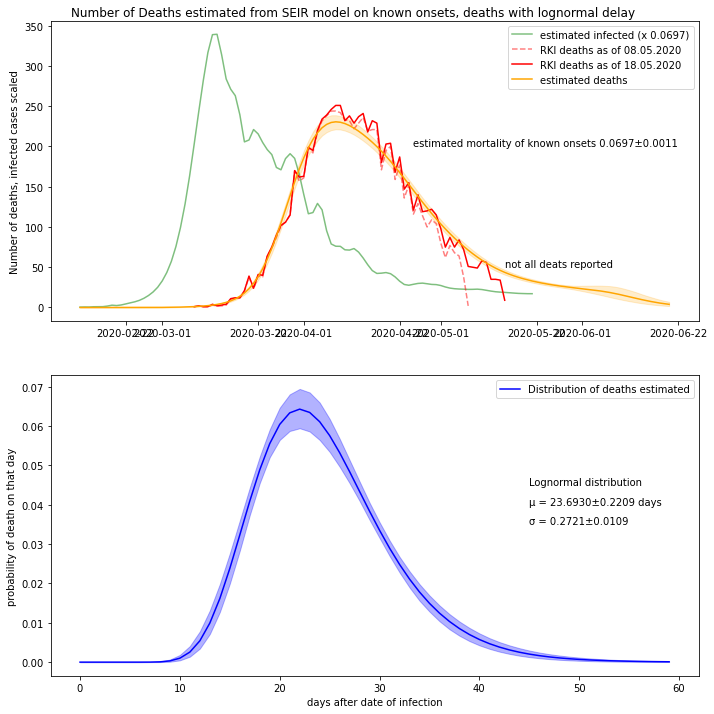

In [45]:

def tt_lognormal(x, mu, sigma):
    x = tt.clip(x,1e-12,1e12) # Checks to improve stability and resilience against NANs
    
    distr = 1/x* tt.exp(-((tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=0)+1e-9)

d = tt.vector()
s_lognormal_median = tt.scalar()
s_lognormal_sigma = tt.scalar()

s_beta = tt_lognormal(d, tt.log(s_lognormal_median), s_lognormal_sigma)
f_beta = theano.function([d,s_lognormal_median,s_lognormal_sigma],[s_beta])

# - - - - - - 

deaths = [1, 2, 1, 1, 4, 2, 3, 4, 11, 12, 12, 21, 39, 24, 41, 40, 64, 75, 90, 102, 106, 115, 170, 162, 163, 199, 195, 220, 234, 239, 246, 251, 251, 232, 238, 229, 237, 241, 218, 232, 229, 180, 203, 204, 168, 187, 147, 155, 121, 140, 119, 120, 122, 115, 98, 75, 87, 75, 84, 72, 51, 50, 49, 58, 56, 35, 35, 34, 9]
deaths = np.asarray(deaths,dtype=np.float64)
deaths_200508 = [1, 2, 1, 1, 3, 2, 2, 3, 10, 12, 12, 20, 38, 23, 39, 38, 64, 74, 87, 101, 106, 115, 170, 157, 161, 199, 192, 218, 232, 238, 244, 244, 242, 233, 232, 222, 229, 236, 219, 221, 221, 171, 195, 200, 159, 177, 136, 152, 116, 129, 114, 100, 109, 104, 80, 62, 77, 68, 64, 38, 2]
death_start = datetime.date(2020,3,8)
deaths_200508 = np.asarray(deaths_200508,dtype=np.float64)
td = pd.date_range(death_start,periods=len(deaths),freq='D')
ts = pd.date_range(model.startdate,periods=len(trace.dead_t[0]),freq='D')


fig, axes = plt.subplots(2,1 , figsize = (10,10),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.08,right=0.98,top=0.96,bottom=0.05)
ax,bx = axes[0,0],axes[1,0]
plasma = plt.cm.plasma

f_death = np.mean(trace.f_death,axis=0)
ax.plot(ts[:len(trace.infected_t[0])],np.mean(trace.infected_t,axis=0)*f_death,color="green",alpha=.5,label="estimated infected (x %.4f)"%f_death)

ax.plot(td[:len(deaths_200508)],deaths_200508,"--",label="RKI deaths as of 08.05.2020",color="red",alpha=.5)
ax.plot(td,deaths,label="RKI deaths as of 18.05.2020",color="red")
ax.plot(ts,np.mean(trace.dead_t,axis=0),color="orange",label="estimated deaths")
ax.fill_between(ts,*np.percentile(trace.dead_t,axis=0,q=(2.5,97.5)),color="orange",alpha=.2)
ax.set_ylabel("Number of deaths, infected cases scaled")
ax.legend()

mfv,mfs = np.mean(trace.f_death,axis=0),np.std(trace.f_death,axis=0)
ax.text(datetime.date(2020,5,15),50,"not all deats reported")
ax.text(datetime.date(2020,4,25),200,"estimated mortality of known onsets %.4f±%.4f"%(mfv,mfs))

fig.suptitle("Number of Deaths estimated from SEIR model on known onsets, deaths with lognormal delay")

dists = []
x = np.arange(0,60,dtype=np.float64)
for d,s in zip(trace.m_death,trace.s_death):
    dists.append(f_beta(x,d,s)[0])
dists = np.array(dists)
mdv,mds = np.mean(trace.m_death,axis=0),np.std(trace.m_death,axis=0)
msv,mss = np.mean(trace.s_death,axis=0),np.std(trace.s_death,axis=0)

bx.plot(x,np.mean(dists,axis=0),color="blue",label="Distribution of deaths estimated")
bx.fill_between(x,*np.percentile(dists,axis=0,q=(2.5,97.5)),alpha=.3,color="blue")
bx.text(45,.045,"Lognormal distribution")
bx.text(45,.04,"µ = %.4f±%.4f days"%(mdv,mds))
bx.text(45,.035,"σ = %.4f±%.4f"%(msv,mss))
bx.set_ylabel("probability of death on that day")
bx.set_xlabel("days after date of infection")

bx.legend()
plt.savefig("EstimatedDeathsLognormalFromSEIR.pdf")
plt.savefig("EstimatedDeathsLognormalFromSEIR.svg")